In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime
from scipy.stats import norm
from math import log, sqrt, exp

In [3]:
spy = yf.Ticker('SPY')
df = spy.history(period="5y")
df.tail()

logreturns = np.log(df.Close/df.Close.shift(1))
sigma = np.std(logreturns, ddof = 1)

sigma

0.013514559914061164

/var/folders/tf/1ns7f6px7g5368d_k6bn57580000gn/T/ipykernel_58918/1083462649.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  stock_price_paths[i, t] = stock_price_paths[i, t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)


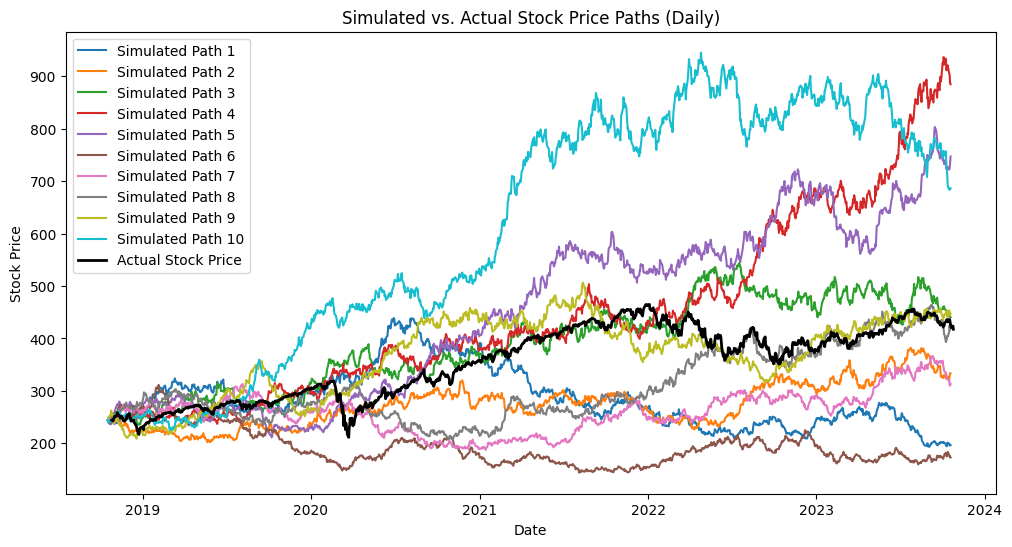

In [4]:
# Generate Geometric Brownian Motion paths

S0 = df['Close'].iloc[0] 
years = 5  
trading_days_per_year = 252  
num_paths = 10 
sigma = np.std(logreturns, ddof = 1)
mu = np.mean(logreturns) + 0.5*sigma**2

N = years * trading_days_per_year + 45
dt = 1
stock_price_paths = np.zeros((num_paths, N + 1))
stock_price_paths[:, 0] = S0

for i in range(num_paths):
    for t in range(1, N + 1):
        z = np.random.standard_normal(1)
        stock_price_paths[i, t] = stock_price_paths[i, t - 1] * np.exp((mu - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * z)

actual_stock_prices = df.iloc[:, [3]]   
date_range = pd.date_range(start='2018-10-18', periods=N + 1, freq='B')  # Adjust the start date as needed

plt.figure(figsize=(12, 6))
for i in range(num_paths):
    plt.plot(date_range, stock_price_paths[i], label=f'Simulated Path {i + 1}')
plt.plot(actual_stock_prices.index, actual_stock_prices['Close'], label='Actual Stock Price', color='black', linewidth=2)
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Simulated vs. Actual Stock Price Paths (Daily)")
plt.legend()
plt.show()

In [5]:
y = np.log(df.Close/df.Close.shift(1))*np.sqrt(252)

In [6]:
y.rolling(252).std()["2023-10-17"]

0.1592000581648528

<b>Question 2:<u>Vanilla European option pricing</u></b>

<p>Use the non-constant volatility model obtained in Question 1(2). Calculate the price of a European call 
option (whose today’s price can be observed in market) using</p>

1. Monte Carlo
 
Use the Geometric Brownian motion obtained in Question 1(1). Calculate the price of the same 
European call option using 

2. Numerical PDE  
3. Binomial Model 
4. Black-Scholes formula 

For each part of 1 to 3, show how accuracy can be improved by increasing computational time. 
Lastly,  

5. Compare the four calculated prices with the “true price” observed in market. Comment on these 
methods based on their efficiency and accuracy. Explain any source of error and make 
suggestions on possible ways to reduce the error.  


Define basic values of option simulation

In [7]:
r_f = 0.0471/365
S_0=436.04#Stock price at 17 Oct 2023
K = 445
simu_times = 1000
time_to_maturity = 30
dividend = 0

## 1. Monte Carlo Simulation

using GARCH model

In [8]:
def eur_call_garch_mc(S, K, r, sigma0, q, T, N, a, b, c, M):

    stockV = []
    dt = T / N
    sqrdt = sqrt(dt)
    logS0 = log(S)
    sumCall = 0
    sumCallSq = 0

    for i in range(M):
        LogS = logS0
        sigma = sigma0
        stock_path = []
        stock_path.append(S)
        
        for j in range(N):
            y = sigma * np.random.standard_normal(1)
            sigma = sqrt(a + b * pow(y,2) + c * pow(sigma,2))
            LogS = LogS + (r - q - 0.5 * pow(sigma,2)) * dt + sqrdt * y
            stock_path.append(exp(LogS))
            
        stockV.append(stock_path)
        CallV = max(exp(LogS) - K,0)
        sumCall += CallV
        sumCallSq += CallV * CallV

    # Calculate the option value and standard error
    CallV = exp(-r * T) * sumCall / M
    std_error = exp(-r * T) * sqrt((sumCallSq - sumCall * sumCall / M) / (M * (M - 1)))

    return CallV, stockV, std_error


In [9]:
a = 3.6602e-06 
b = 0.20
c = 0.78
num_of_path_monte = [1000,5000,10000,50000,70000,100000,120000,150000]
sigma0 = y.rolling(252).std()["2023-10-17"]

In [10]:
try:
    result_monte = pd.read_csv("Monte_Carlo_result.csv",index_col=0)
    result_monte = result_monte.rename({'0':"num_of_path",'1':"value",'2':"stder"},axis=1)
except:
    value = []
    stder = []
    for i in num_of_path_monte: 
        value_i,stock_price_i,stder_i=eur_call_garch_mc(S_0,K,r_f,sigma0,dividend,time_to_maturity,i,a,b,c,1000)
        value.append(value_i)
        stder.append(stder_i)
    result_monte = pd.DataFrame([num_of_path_monte,value,stder])
    result_monte.T.to_csv("Monte_Carlo_result.csv")

In [11]:
for i in num_of_path_monte:
     print("Options price using Monte Carlo Simulation with",i,"steps is :",result_monte['value'][result_monte['num_of_path']==i].values[0])

Options price using Monte Carlo Simulation with 1000 steps is : 25.568228193977635
Options price using Monte Carlo Simulation with 5000 steps is : 13.863539691932129
Options price using Monte Carlo Simulation with 10000 steps is : 11.574832690272826
Options price using Monte Carlo Simulation with 50000 steps is : 10.0166799092211
Options price using Monte Carlo Simulation with 70000 steps is : 10.61358170612152
Options price using Monte Carlo Simulation with 100000 steps is : 9.832335880283292
Options price using Monte Carlo Simulation with 120000 steps is : 9.68430349276174
Options price using Monte Carlo Simulation with 150000 steps is : 9.6865647633775


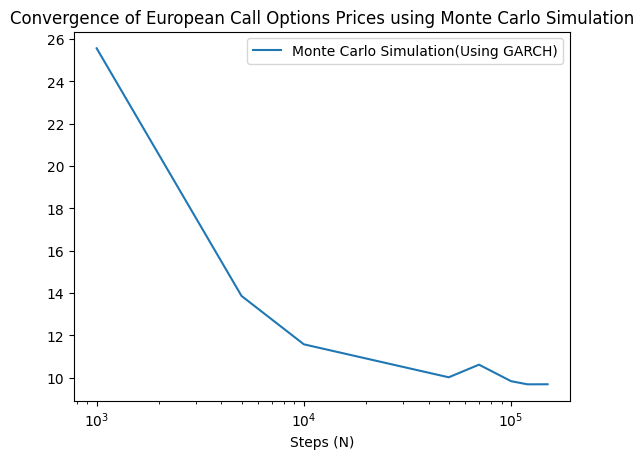

In [12]:
plt.plot(result_monte.num_of_path,result_monte.value, label = "Monte Carlo Simulation(Using GARCH)")
plt.legend()
plt.xlabel("Steps (N)")
plt.xscale("log")
plt.title("Convergence of European Call Options Prices using Monte Carlo Simulation")
plt.show()

In [13]:
for i in num_of_path_monte:
     print("Standard Error of Options price using Monte Carlo Simulation with",i,"steps is :",result_monte['stder'][result_monte['num_of_path']==i].values[0])

Standard Error of Options price using Monte Carlo Simulation with 1000 steps is : 1.84767881203496
Standard Error of Options price using Monte Carlo Simulation with 5000 steps is : 0.7965108610423253
Standard Error of Options price using Monte Carlo Simulation with 10000 steps is : 0.6354242098235565
Standard Error of Options price using Monte Carlo Simulation with 50000 steps is : 0.5743207859762571
Standard Error of Options price using Monte Carlo Simulation with 70000 steps is : 0.5883255658808976
Standard Error of Options price using Monte Carlo Simulation with 100000 steps is : 0.5647548085855706
Standard Error of Options price using Monte Carlo Simulation with 120000 steps is : 0.5612835814732222
Standard Error of Options price using Monte Carlo Simulation with 150000 steps is : 0.5502954825508328


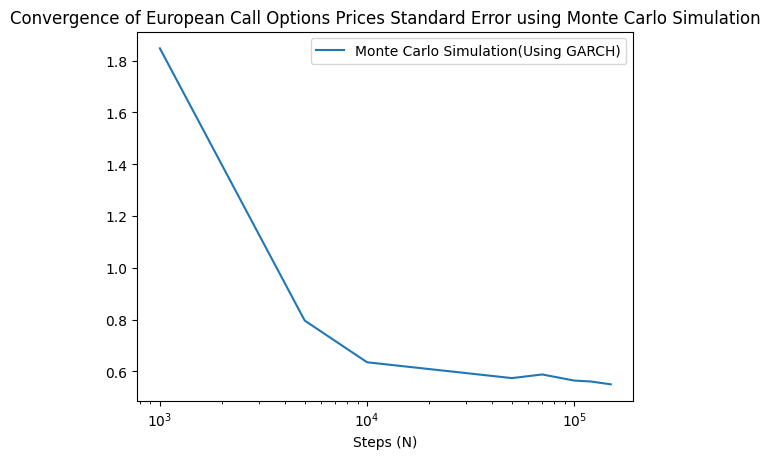

In [14]:
plt.plot(result_monte.num_of_path,result_monte.stder, label = "Monte Carlo Simulation(Using GARCH)")
plt.legend()
plt.xlabel("Steps (N)")
plt.xscale("log")
plt.title("Convergence of European Call Options Prices Standard Error using Monte Carlo Simulation")
plt.show()

## 2. Using PDE method under GBM

In [15]:
import numpy as np

def crank_nicolson(a, y, L, z1, b1, zL, bL):
    # Initialize arrays for c, b, u, and z
    c = np.zeros(L)
    b = np.zeros(L)
    u = np.zeros(L)
    z = np.zeros(L)

    # Set initial values
    u[0] = z1
    b[0] = b1

    # Calculate values for c, b, u, and z
    for j in range(1, L - 1):
        z[j] = a[3] * y[j] + a[1] * y[j + 1] + a[2] * y[j - 1]
        u[j] = (a[2] * u[j - 1] + z[j]) / (a[0] - a[2] * b[j - 1])
        b[j] = a[1] / (a[0] - a[2] * b[j - 1])

    c[L - 1] = (zL + bL * u[L - 1]) / (1 - bL * b[L - 1])

    for j in range(L - 2, 0, -1):
        c[j] = u[j] + b[j] * c[j + 1]

    return c

def euro_call_cranknicolson(S0, K, r, sigma, q, T, N, M, Dist):
    # Define parameters
    dt = T / N
    dx = Dist / M
    dx2 = dx * dx
    u = np.exp(dx)
    
    # Initialize variables
    sig2 = sigma * sigma
    nu = r - q - sig2 / 2
    St = S0 * np.exp(Dist)
    Sb = S0 * np.exp(-Dist)
    a = np.zeros(4)
    a[0] = r / 2 + 1 / dt + sig2 / (2 * dx2)
    a[1] = sig2 / (4 * dx2) + nu / (4 * dx)
    a[2] = a[1] - nu / (2 * dx)
    a[3] = -a[0] + 2 / dt

    # Initialize y array
    L = 2 * M + 1
    y = np.zeros(L)
    
    # Calculate call value at the final date
    S = Sb
    for j in range(L):
        y[j] = max(S - K, 0)
        S *= u

    # Calculate the call value at the penultimate date
    z1 = 0
    b1 = 1
    zL = St - St / u
    bL = 1
    CallV = crank_nicolson(a, y, L, z1, b1, zL, bL)

    # Back up to date 0
    for i in range(N - 2, -1, -1):
        CallV = crank_nicolson(a, CallV, L, z1, b1, zL, bL)

    # Return the value at the middle node
    return CallV[M]
    

In [16]:
num_of_path = [1,5,10,25,50,100,250,500,1000,3000,5000]
pde_value = []

for i in num_of_path: 
    value_i = euro_call_cranknicolson(S_0,K,r_f,sigma,0,30,i,1000,10)
    pde_value.append(value_i)

In [17]:
for i in range(len(num_of_path)):
     print("Options price using Crank Nicolson Method with",num_of_path[i],"steps is :",pde_value[i])

Options price using Crank Nicolson Method with 1 steps is : 9.974758593768446
Options price using Crank Nicolson Method with 5 steps is : 9.641457713705421
Options price using Crank Nicolson Method with 10 steps is : 9.656100512462132
Options price using Crank Nicolson Method with 25 steps is : 9.656391708398107
Options price using Crank Nicolson Method with 50 steps is : 9.655996355925513
Options price using Crank Nicolson Method with 100 steps is : 9.655897497309242
Options price using Crank Nicolson Method with 250 steps is : 9.655869815431963
Options price using Crank Nicolson Method with 500 steps is : 9.655865860824909
Options price using Crank Nicolson Method with 1000 steps is : 9.655864872170735
Options price using Crank Nicolson Method with 3000 steps is : 9.65586457923545
Options price using Crank Nicolson Method with 5000 steps is : 9.655864555807517


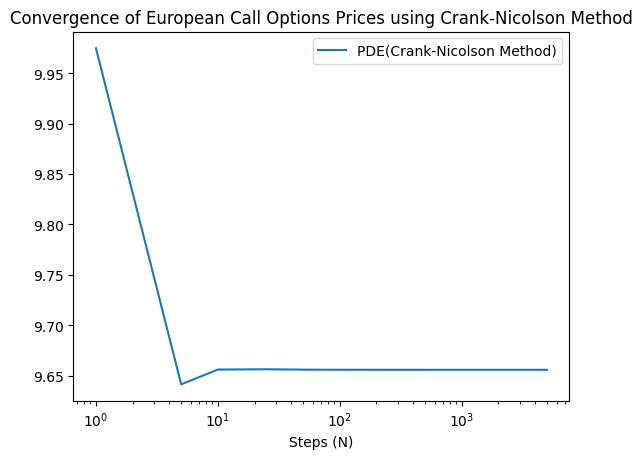

In [19]:
plt.plot(num_of_path,pde_value, label = "PDE(Crank-Nicolson Method)")
plt.legend()
plt.xlabel("Steps (N)")
plt.xscale("log")
plt.title("Convergence of European Call Options Prices using Crank-Nicolson Method")
plt.show()

## 3. Using Binomial Tree

In [20]:
def Binomial(S, K, r, sigma, T, N):
  u = exp(sigma*pow(T/N,0.5))
  d = 1/u
  q = (exp(r*T/N) - d)/(u - d)
  dt = T/N
  df = exp(-r*T/N)
  NodeList = [None]*(N+1)
    
  # Calculation of the payoff of final (Nth) steps Payoff
  Ending_Node_Payoff = np.asarray([(S*pow(u,i)*pow(d,N-i)) for i in range(N+1)])

  # Declaration of a Dynamic array:
  #Array(NodePnL) will be used for loop later; the size of the array will decrease by 1 in every loop 
  NodePnL = np.maximum(Ending_Node_Payoff - K, 0)

  # Save the payoff of last step into NodeList
  NodeList[-1] = NodePnL
  for i in range(N,0,-1):
    NodePnL=df*(q*NodePnL[1:] + (1-q)*NodePnL[:-1])
    NodeList[i-1] = NodePnL

  return NodeList[0][0]

In [21]:
bin_price = Binomial(S_0, K, r_f, sigma, time_to_maturity, 300)
print("The binomial option price is", bin_price)

The binomial option price is 9.688851796665851


In [22]:
N_Step_df = [None]*len(num_of_path)

for i, j in enumerate(num_of_path):
  output = Binomial(S_0, K, r_f, sigma, time_to_maturity, j)
  N_Step_df[i] = output
  print("Options price using Binomial Tree with ",j," steps is :",output)

Options price using Binomial Tree with  1  steps is : 12.410960998054028
Options price using Binomial Tree with  5  steps is : 9.839759837123518
Options price using Binomial Tree with  10  steps is : 9.973813425873951
Options price using Binomial Tree with  25  steps is : 9.699804172525374
Options price using Binomial Tree with  50  steps is : 9.628626965534941
Options price using Binomial Tree with  100  steps is : 9.706195513035274
Options price using Binomial Tree with  250  steps is : 9.681182083945147
Options price using Binomial Tree with  500  steps is : 9.676766069144277
Options price using Binomial Tree with  1000  steps is : 9.68238821836143
Options price using Binomial Tree with  3000  steps is : 9.680971835473198
Options price using Binomial Tree with  5000  steps is : 9.6803375897559


## 4. Using Black-Scholes Formula

In [23]:
def European_Call(S, K, r, T):
  if S > K:
    payoff = S - k
  elif S < K:
    payoff = 0
  return payoff

def d1(S, K, r, sigma, T):
  dis = (log(S/K)+T*(r+0.5*(pow(sigma, 2))))/(sigma*pow(T,0.5))
  return dis

def d2(S, K, r, sigma, T):
  dis = (log(S/K)+T*(r-0.5*(pow(sigma, 2))))/(sigma*pow(T,0.5))
  return dis

def bs_model(S, K, r, sigma, T, optionType):
  if optionType == "Call":
    payoff = S*norm.cdf(d1(S,K,r,sigma,T),0,1) - K*exp(-r*T)*norm.cdf(d2(S,K,r,sigma,T),0,1)
  return payoff

In [24]:
# Option price using Black Scholes Model
BS_price = bs_model(S_0, K, r_f, sigma, time_to_maturity, "Call")
print("The binomial option price is", BS_price)

The binomial option price is 9.679962184069609


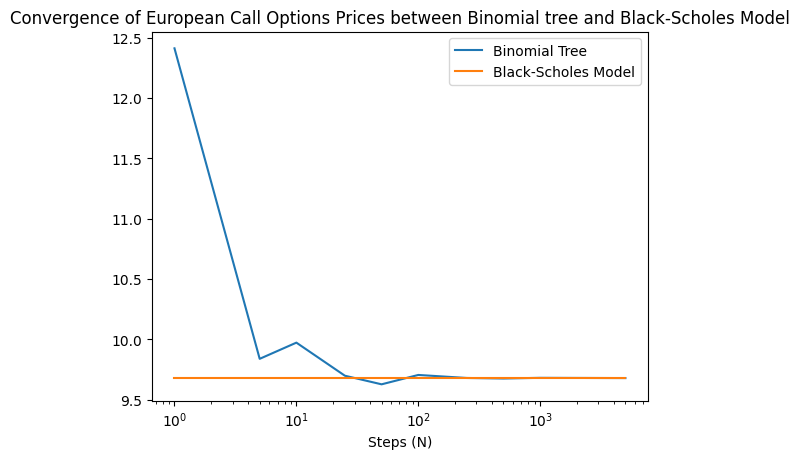

In [25]:
BS_df = [BS_price for i in range(len(num_of_path))]

plt.plot(num_of_path, N_Step_df, label = "Binomial Tree")
plt.plot(num_of_path, BS_df, label = "Black-Scholes Model")
plt.legend()
plt.xlabel("Steps (N)")
plt.xscale("log")
plt.title("Convergence of European Call Options Prices between Binomial tree and Black-Scholes Model")
plt.show()